In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

##HIPOTESIS NULL

H0: Tidak ada perbedaan signifikan dalam rata-rata durasi sesi antara pengguna yang menggunakan Antarmuka Versi A dan pengguna yang menggunakan Antarmuka Versi B.

```
# This is formatted as code
```



##IMPORT AND UNDERSTANDING DATA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/finalproject-ds/ab_testing_log.csv')
df.head(20)

Mounted at /content/drive


,Session_ID,Date,Interface_Group,Session_Duration_Minutes,Device_Type,Is_Checkout
0,S018,2025-10-02,B,7.83,Mobile,1
1,S080,2025-10-05,A,5.29,Mobile,0
2,S105,2025-10-03,Version B,6.88,Mobile,0
3,S175,2025-10-09,old_version,4.92,Mobile,0
4,S149,2025-10-02,new_version,23.97,Desktop,1
5,S158,2025-10-02,B,8.15,Mobile,0
6,S180,2025-10-04,test_group,12.64,Tablet,0
7,S056,2025-10-05,B,9.06,Mobile,1
8,S027,2025-10-02,test_group,4.90,Mobile,0
9,S014,2025-10-08,B,3.37,Tablet,0


##CHECK DATA QUALITY

In [3]:
print(df.isnull().sum())
df.info()

print(df['Interface_Group'].unique())
print(df['Interface_Group'].value_counts())
print(df['Device_Type'].unique())

Session_ID                  0
Date                        0
Interface_Group             0
Session_Duration_Minutes    0
Device_Type                 0
Is_Checkout                 0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Session_ID                200 non-null    object 
 1   Date                      200 non-null    object 
 2   Interface_Group           200 non-null    object 
 3   Session_Duration_Minutes  200 non-null    float64
 4   Device_Type               200 non-null    object 
 5   Is_Checkout               200 non-null    int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB
['B' 'A' 'Version B' 'old_version' 'new_version' 'test_group'
 'control_group' 'Version A']
Interface_Group
B                57
A                53
old_version      19
new_version      18
Version A    

#Explanasi

Pada Interface_Group ditemukan inkonsistensi dalam penamaan versi interface. Karena itu dataset ini perlu dirapikan dan distandarisasi sebelum digunakan. Selain hal tersebut, tidak ditemukan missing values pada kolom dataset ini.

##EXPLORING STATISTICS

In [4]:
df.describe()

,Session_Duration_Minutes,Is_Checkout
count,200.00000,200.000000
mean,6.31925,0.420000
std,3.25340,0.494797
min,1.56000,0.000000
25%,4.16000,0.000000
50%,5.63000,0.000000
75%,7.79000,1.000000
max,24.73000,1.000000


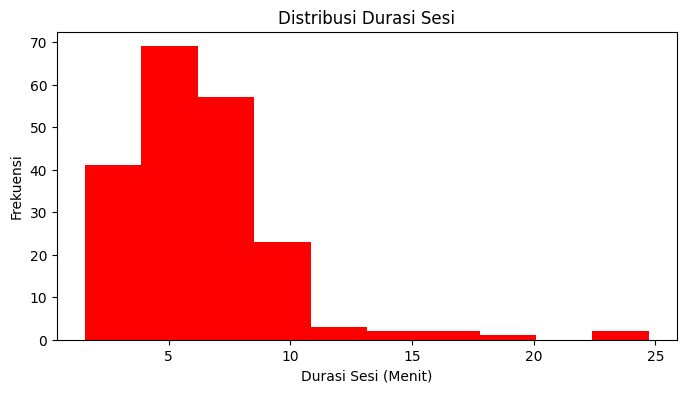

In [5]:
plt.figure(figsize=(8, 4))
plt.hist(df['Session_Duration_Minutes'], color='red')
plt.title('Distribusi Durasi Sesi')
plt.xlabel('Durasi Sesi (Menit)')
plt.ylabel('Frekuensi')
plt.show()

#Eksplanasi
Sebagian besar pengguna cenderung memiliki durasi sesi yang relatif singkat. Ini adalah pola umum dalam banyak aplikasi atau situs web.

Terdapat sejumlah kecil pengguna yang sangat terlibat (atau mungkin meninggalkan aplikasi terbuka), yang menghasilkan durasi sesi yang sangat panjang, menciptakan 'ekor' pada distribusi (outlier). Hal ini menunjukkan variasi perilaku pengguna yang signifikan terkait dengan lamanya waktu yang dihabiskan di aplikasi. Namun karena tidak terlalu berpengaruh signifikan pada nilai mean pada distribusi, maka data tersebut (outlier) tidak dihapus/dihilangkan dari dataset.

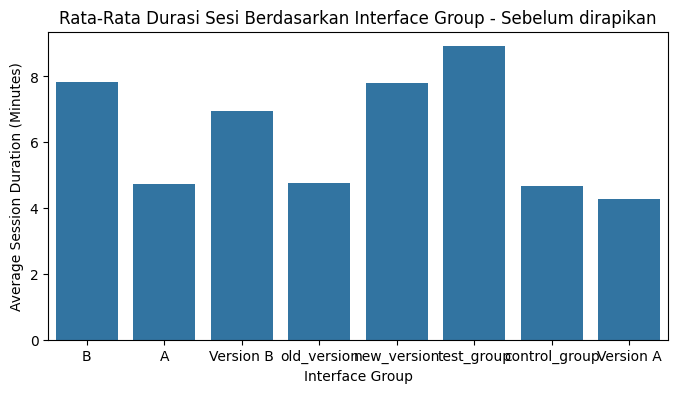

In [6]:
plt.figure(figsize=(8, 4))
sns.barplot(x='Interface_Group', y='Session_Duration_Minutes', data=df, errorbar=None)
plt.title('Rata-Rata Durasi Sesi Berdasarkan Interface Group - Sebelum dirapikan')
plt.xlabel('Interface Group')
plt.ylabel('Average Session Duration (Minutes)')
plt.show()

##CLEANING DATA AND HANDLING ISSUES

Merapikan sistem penamaan versi interface menjadi,
- Versi A
- Versi B

untuk konsistensi dan standarisasi dalam penamaan.

In [7]:
df['Interface_Group'] = df['Interface_Group'].replace({'A': 'Versi A', 'old_version': 'Versi A', 'control_group': 'Versi A', 'Version A': 'Versi A'})
df['Interface_Group'] = df['Interface_Group'].replace({'B': 'Versi B', 'Version B': 'Versi B', 'new_version': 'Versi B', 'test_group': 'Versi B'})

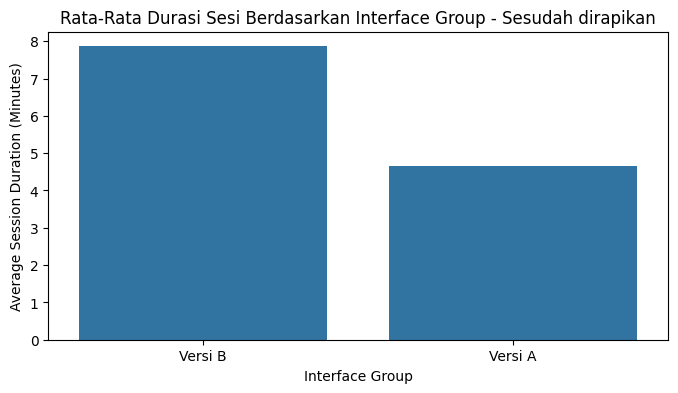

In [8]:
plt.figure(figsize=(8, 4))
sns.barplot(x='Interface_Group', y='Session_Duration_Minutes', data=df, errorbar=None)
plt.title('Rata-Rata Durasi Sesi Berdasarkan Interface Group - Sesudah dirapikan')
plt.xlabel('Interface Group')
plt.ylabel('Average Session Duration (Minutes)')
plt.show()

##COMPARISON TEST

In [9]:
versi_a = df[df['Interface_Group'] == 'Versi A']['Session_Duration_Minutes']
versi_b = df[df['Interface_Group'] == 'Versi B']['Session_Duration_Minutes']

In [10]:
ttest = stats.ttest_ind(versi_a, versi_b)
print(ttest)

TtestResult(statistic=np.float64(-8.013369666342099), pvalue=np.float64(9.441065490556777e-14), df=np.float64(198.0))


In [11]:
t_stat, p_val = ttest
print(f"t-Statistic: {t_stat:.5f}")
print(f"p-Value: {p_val:.10f}")

t-Statistic: -8.01337
p-Value: 0.0000000000


In [12]:
alpha = 0.05
if p_value < alpha:
    print("Conclusion: Reject the null hypothesis...")
else:
    print("Conclusion: Fail to reject the null hypothesis...")

NameError: name 'p_value' is not defined

#Eksplanasi
Berdasarkan hasil t-test ditemukan:
- t-Statistic: -8.01337 Nilai t-statistik yang cukup besar (secara absolut) dan negatif menunjukkan adanya perbedaan yang signifikan antara rata-rata durasi sesi kedua kelompok. Tanda negatif secara spesifik mengindikasikan bahwa rata-rata durasi sesi kelompok yang diwakili oleh versi_b (Versi B) lebih tinggi dibandingkan dengan kelompok versi_a (Versi A).
- p-Value: 0.0000000000 P-value yang sangat kecil (mendekati nol) ini adalah indikator yang sangat kuat. Dalam pengujian hipotesis, jika p-value lebih kecil dari tingkat signifikansi yang di tetapkan (0.05), kita akan menolak hipotesis nol.

#Kesimpulan
Ada perbedaan yang sangat signifikan secara statistik dalam durasi sesi antara dua kelompok antarmuka (Versi A dan Versi B). Ini berarti perbedaan rata-rata durasi sesi yang diamati sangat kecil kemungkinannya terjadi karena kebetulan semata. Berdasarkan nilai t-statistik, kita bisa menyimpulkan bahwa antarmuka yang diwakili oleh versi_b (yakni 'Versi B') menghasilkan durasi sesi yang secara signifikan lebih lama dibandingkan dengan antarmuka 'Versi A'.

##RESULT VISUALIZATION

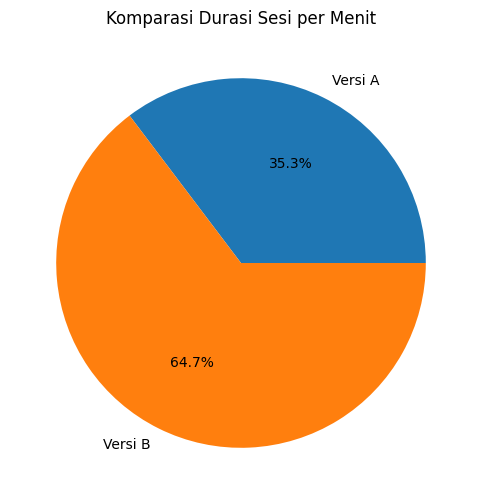

In [ ]:
data_pie = df.groupby('Interface_Group')['Session_Duration_Minutes'].sum()

plt.figure(figsize=(6, 6))
plt.pie(data_pie, labels=data_pie.index, autopct='%1.1f%%')
plt.title('Komparasi Durasi Sesi per Menit')
plt.show()

##Insight

Pie chart ini secara visual menguatkan temuan utama: 'Versi B' menyumbang proporsi durasi sesi total yang jauh lebih besar dibandingkan 'Versi A'. Ini menunjukkan bahwa secara keseluruhan, pengguna menghabiskan lebih banyak waktu di aplikasi ketika disajikan dengan antarmuka 'Versi B'. Ini secara langsung menjawab pertanyaan manajemen tentang apakah 'Versi B' sukses membuat user bertahan lebih lama.

###Rekomendasi untuk CTO (Chief Technology Officer):

- **Validasi Hipotesis:** Kekhawatiran Anda bahwa 'Versi B' mungkin membingungkan atau berat tidak tercermin dalam metrik durasi sesi. Sebaliknya, pengguna justru menghabiskan lebih banyak waktu dengan antarmuka baru ini.
- **Rekomendasi:** Berdasarkan bukti kuat ini, kami merekomendasikan untuk melanjutkan peluncuran 'Versi B' secara penuh. Namun, untuk tetap mengatasi potensi isu performa atau kompleksitas, disarankan untuk menerapkan monitoring teknis yang ketat setelah peluncuran penuh (misalnya, memantau loading times, penggunaan CPU/memori, dan crash rates) untuk memastikan tidak ada dampak negatif tersembunyi yang muncul pada skala yang lebih besar.

###Rekomendasi untuk Head of Design:

- **Konfirmasi Keyakinan:** Keyakinan Anda bahwa 'Versi B' jauh lebih engaging terbukti benar berdasarkan data durasi sesi. Desain baru ini berhasil memicu perilaku pengguna yang lebih lama di aplikasi.
- **Rekomendasi:** Lanjutkan dengan strategi desain yang serupa dengan 'Versi B'. Tim desain disarankan untuk mengidentifikasi dan mendokumentasikan elemen-elemen desain spesifik mana yang berkontribusi pada peningkatan engagement ini. Hal ini penting untuk mengaplikasikan pembelajaran ini pada fitur-fitur dan pengembangan produk di masa depan. Pertimbangkan juga untuk melakukan riset kualitatif (survei, wawancara) untuk memahami mengapa pengguna merasa lebih betah dengan 'Versi B'.


#RECOMENDATION
Berdasarkan seluruh analisis yang telah kita lakukan, berikut adalah rekomendasi umum kepada manajemen:

- Rekomendasi Final: **Peluncuran Penuh 'Versi B' Sangat Direkomendasikan**

Analisis data menunjukkan bahwa antarmuka baru 'Versi B' secara signifikan lebih berhasil dalam meningkatkan durasi sesi pengguna dibandingkan dengan antarmuka lama 'Versi A'.

###Langkah Selanjutnya:

Meskipun durasi sesi adalah indikator kunci engagement, kami merekomendasikan untuk juga:

- **Memantau Metrik KPI Lain:** Sebelum peluncuran penuh ke seluruh dunia, pastikan untuk menganalisis metrik penting lainnya seperti tingkat konversi, bounce rate, kepuasan pengguna (melalui survei atau feedback), dan metrik teknis (kecepatan, stabilitas). Hal ini untuk memastikan bahwa peningkatan durasi sesi tidak datang dengan mengorbankan aspek lain dari pengalaman pengguna atau tujuan bisnis.
- **Rencana Peluncuran Bertahap:** Pertimbangkan peluncuran bertahap ke segmen pengguna yang lebih luas untuk memvalidasi temuan ini pada skala yang lebih besar dan mengidentifikasi masalah yang mungkin muncul sebelum peluncuran global.

